In [23]:
# train_mobilenet.ipynb

# ===== 1. IMPORT LIBRARIES =====
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix



In [24]:
# ===== 2. CONFIGURATION =====
dataset_dir = r"/Users/sonyzaman/Desktop/cvrp_final_assignment/face_dataset"
img_size = (224, 224)
batch_size = 16
epochs = 30


In [25]:
# ===== 3. DATA AUGMENTATION & GENERATORS =====
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 464 images belonging to 3 classes.
Found 115 images belonging to 3 classes.


In [26]:

# Save class names
label_map = train_gen.class_indices
class_names = list(label_map.keys())
np.save("label_map.npy", label_map)


In [27]:
# ===== 4. BUILD MODEL =====
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
# ===== 5. CALLBACKS =====
callbacks = [
    ModelCheckpoint("mobilenet_face_model.keras", save_best_only=True, monitor='val_loss', verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', verbose=1)
]


In [29]:
# ===== 6. TRAIN MODEL =====
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)



Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2654 - loss: 1.7785
Epoch 1: val_loss improved from inf to 0.48477, saving model to mobilenet_face_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.2696 - loss: 1.7649 - val_accuracy: 0.9043 - val_loss: 0.4848
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7370 - loss: 0.6765
Epoch 2: val_loss improved from 0.48477 to 0.15965, saving model to mobilenet_face_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7384 - loss: 0.6724 - val_accuracy: 0.9913 - val_loss: 0.1596
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9180 - loss: 0.2749
Epoch 3: val_loss improved from 0.15965 to 0.06859, saving model to mobilenet_face_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9184 - loss: 0.2743 - val_accuracy: 1.0000 - val_loss: 0.0686
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9467 - loss: 0.1962
Epoch 4: val_loss improved from 0.06859

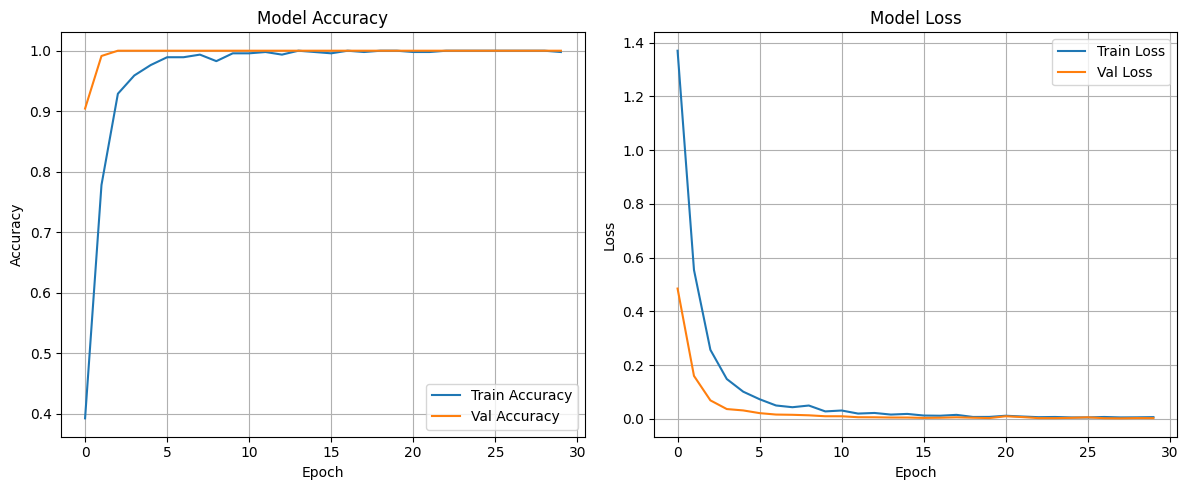

In [30]:
# ===== 7. PLOT ACCURACY & LOSS =====
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


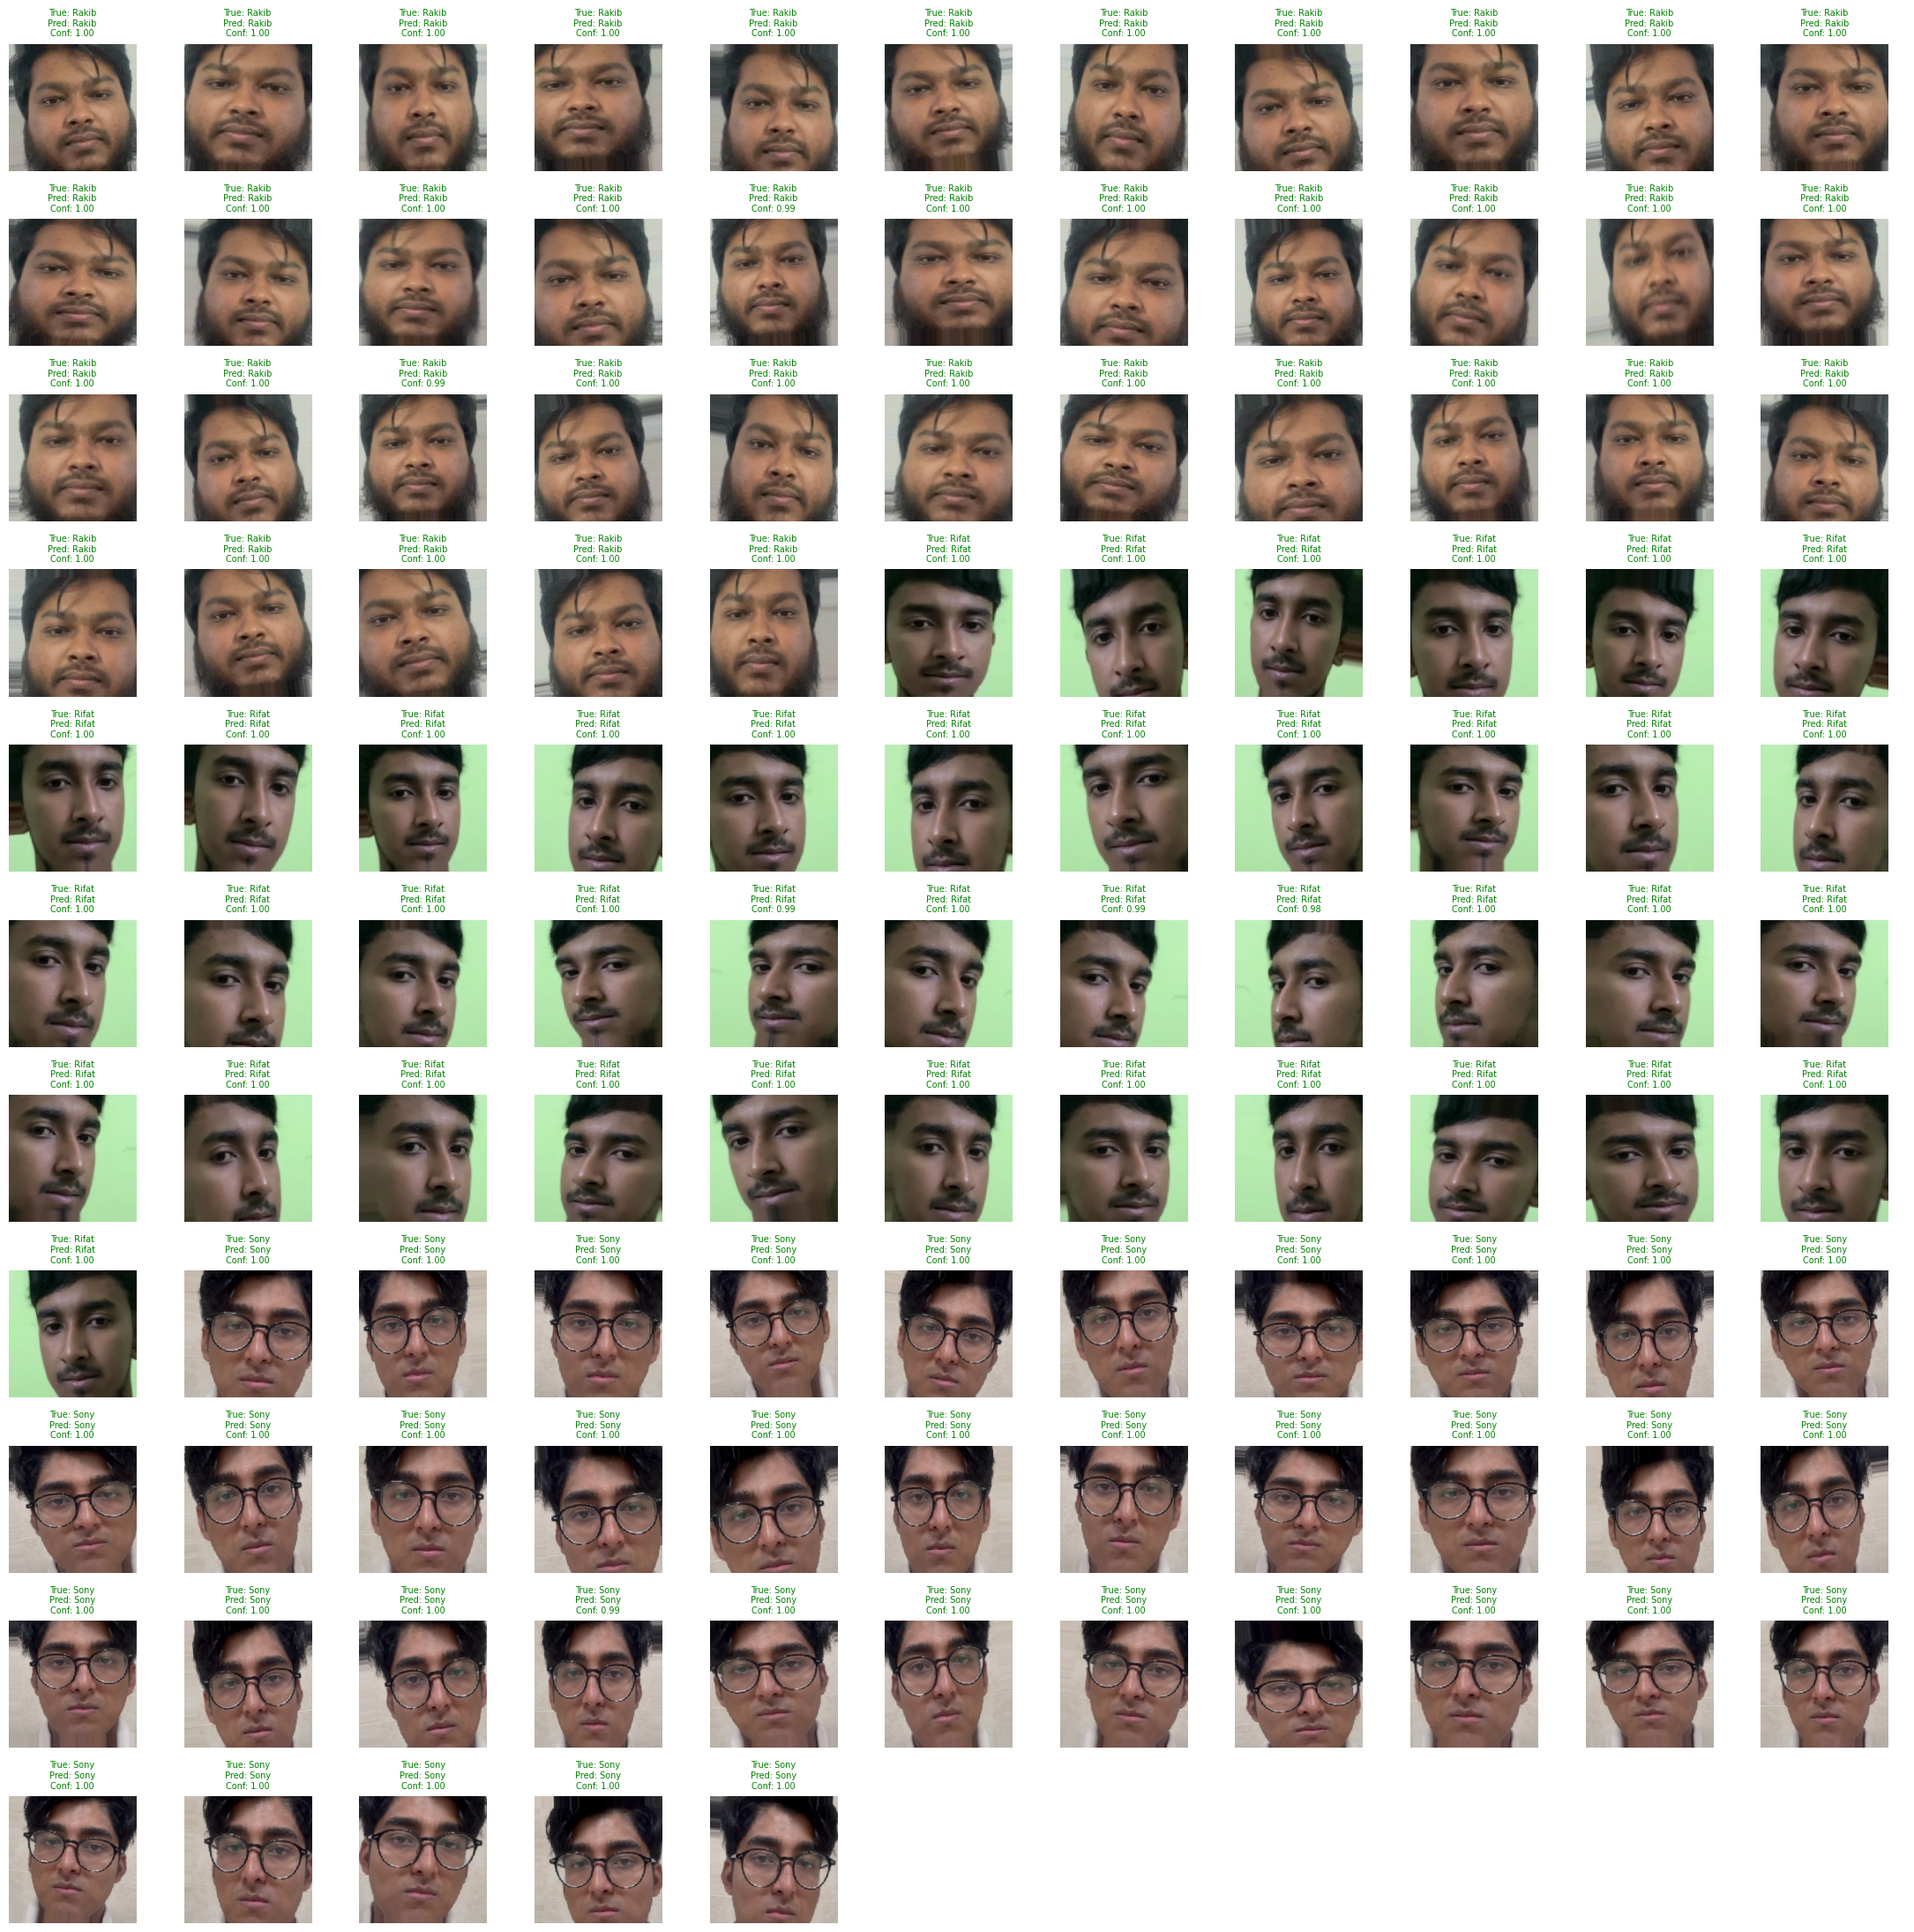

In [35]:

# ===== PREDICT & VISUALIZE VALIDATION SET =====

# Reset the generator to ensure it starts from the beginning
val_gen.reset()

# Predict on all validation data
predictions = model.predict(val_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
confidence_levels = np.max(predictions, axis=1)
y_true = val_gen.classes

# Get class names from saved label map
class_names = list(np.load("label_map.npy", allow_pickle=True).item().keys())

# Total number of images
num_images = len(y_true)
grid_size = int(np.ceil(np.sqrt(num_images)))

# Load all images from val_gen
val_imgs = []
val_labels = []

# Collect all batches from generator
for i in range(len(val_gen)):
    imgs, labels = val_gen[i]
    val_imgs.extend(imgs)
    val_labels.extend(labels)

val_imgs = np.array(val_imgs)
val_labels = np.array(val_labels)

# Visualization
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
axes = axes.ravel()

for i in range(num_images):
    img = (val_imgs[i] + 1) / 2.0
    axes[i].imshow(img)
    axes[i].axis('off')

    true_label = class_names[np.argmax(val_labels[i])]
    predicted_label = class_names[y_pred[i]]
    confidence = confidence_levels[i]
    color = 'green' if predicted_label == true_label else 'red'

    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}",
                      color=color, fontsize=7)

# Hide any remaining empty plots
for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

